 # Start

### Importing the Libraries

In [28]:
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import pandas as pd

from ESN_Cell import ESN
from ddeint import ddeint

### Resetting the Graph

In [29]:
tf.reset_default_graph()

### Initializing the DataFrame to store Results

In [30]:
df = pd.DataFrame(columns=['n','Spectral_Radius','MSE','alpha'])

## Simulating the Mackey-Glass Equation
#### for 6 different 'n' values

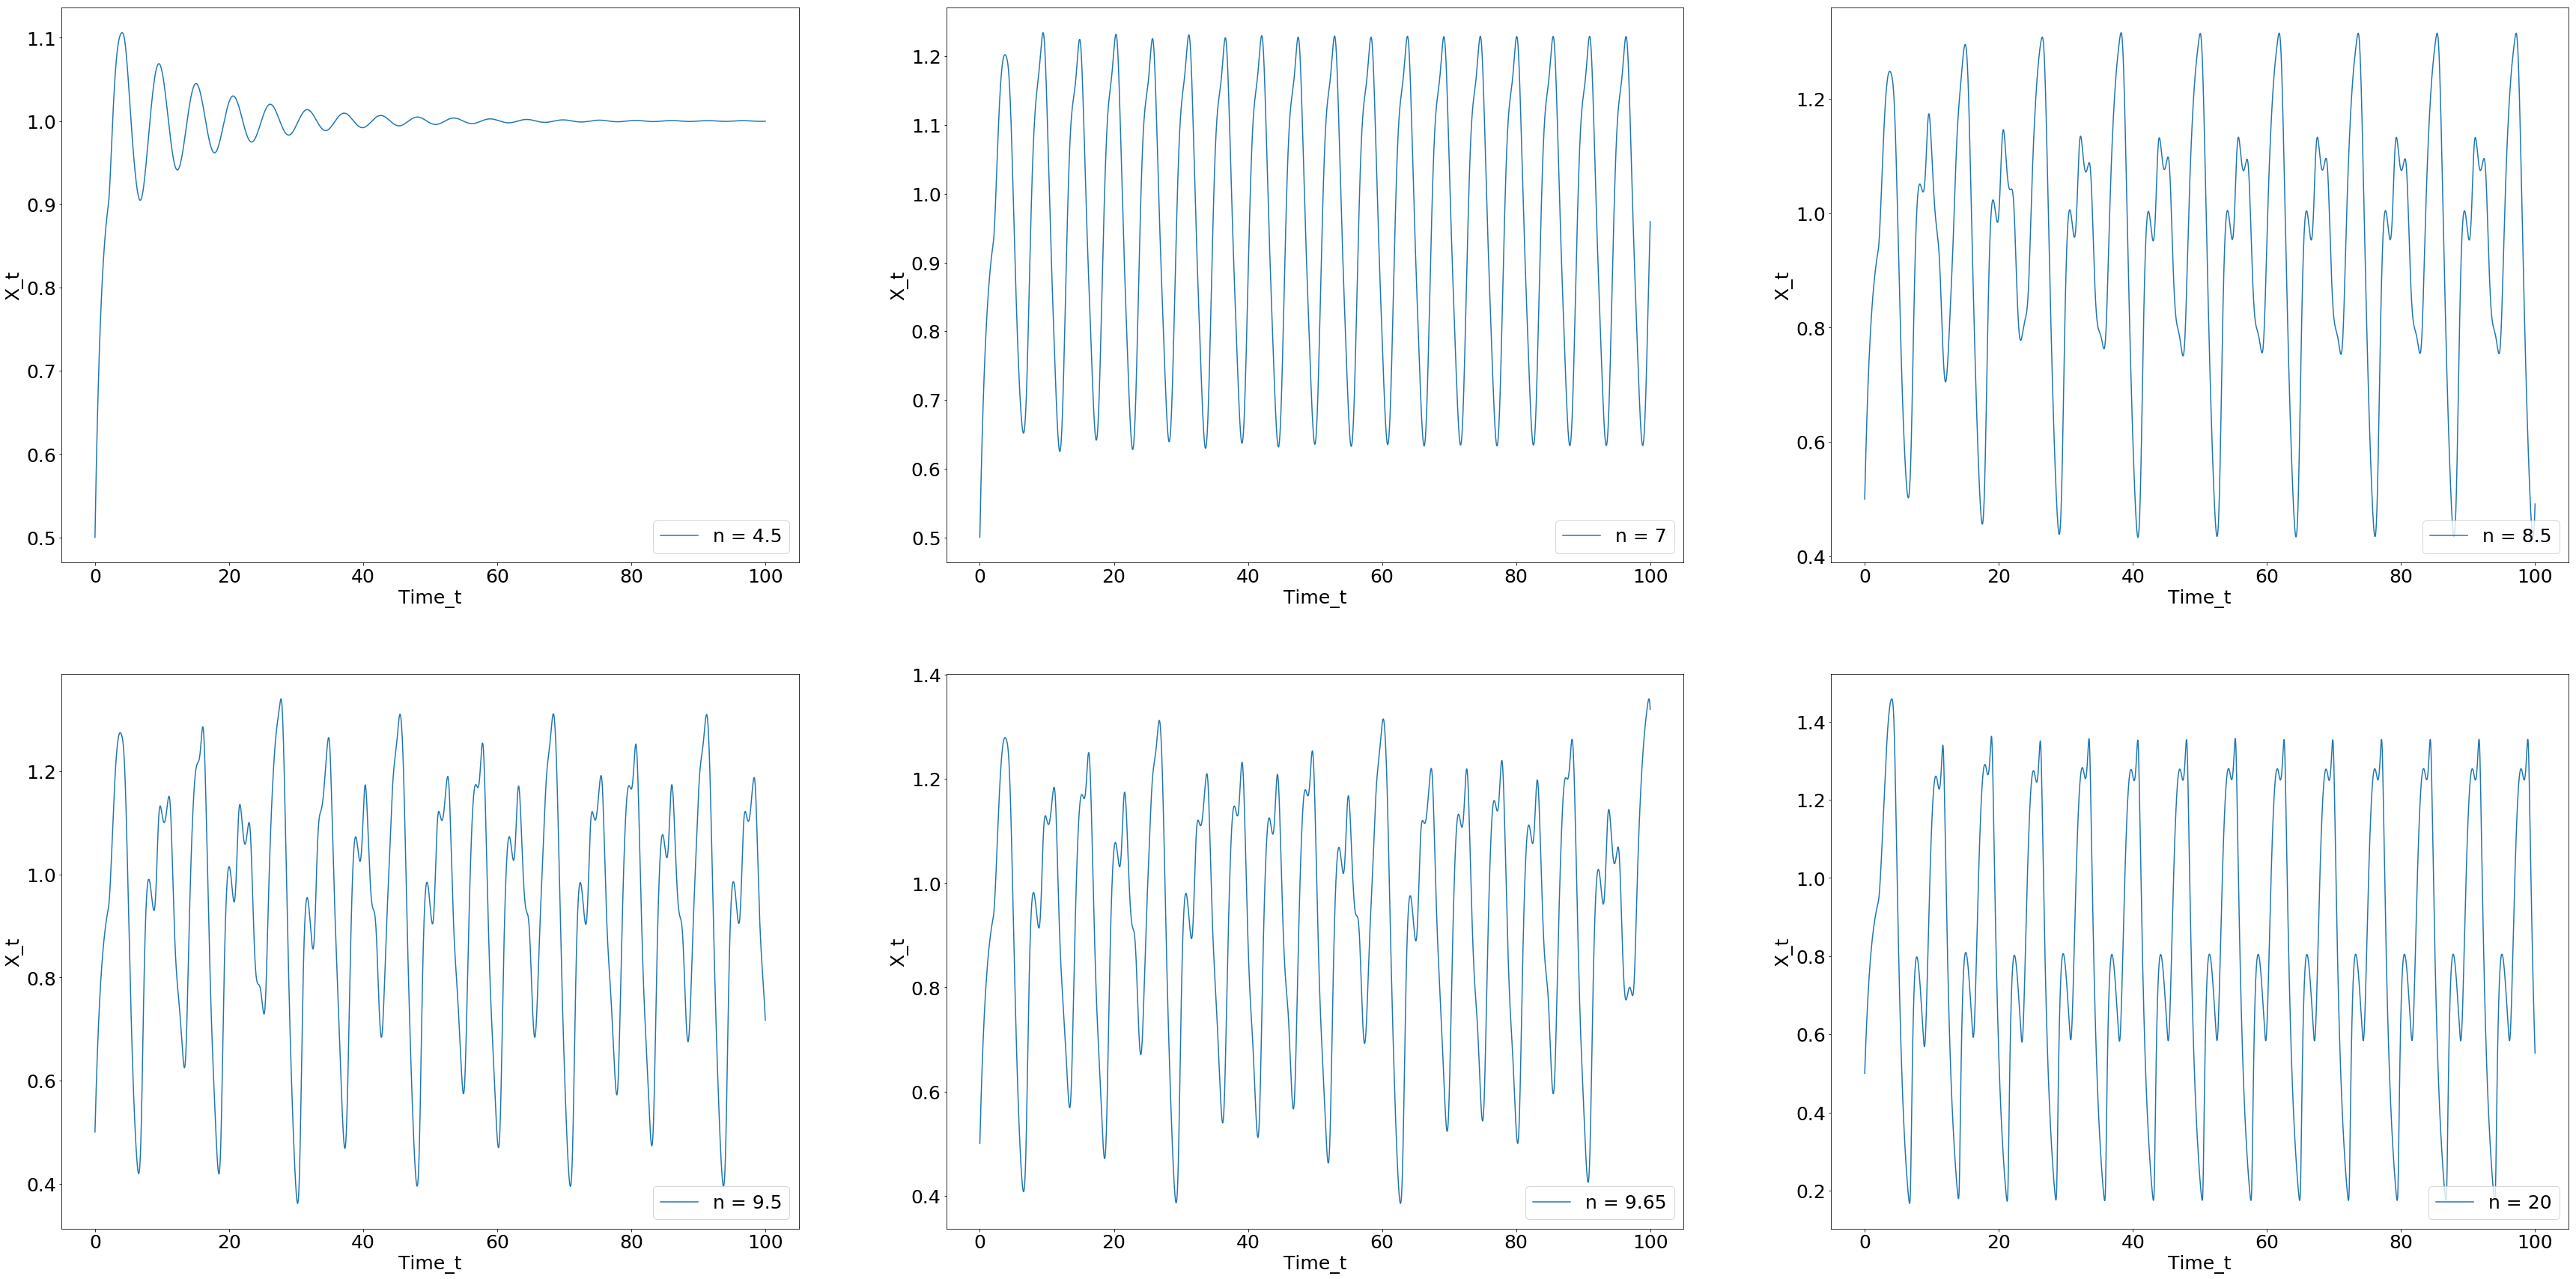

In [5]:
model = lambda X,t,beta,n,tau,gamma : beta*((X(t-tau))/(1 + X(t-tau)**n)) - gamma*X(t)

X_0 = lambda t:0.5 # history before t=0

X_ts = {}

plt.figure(figsize=(60,30))
plt.rcParams.update({'font.size': 25})

for i, n in enumerate([4.5, 7, 8.5, 9.5, 9.65, 20]):
    t = linspace(0,100,10000)
    X_t = ddeint(model, X_0, t, fargs=(2, n, 2, 1)) #beta=2, n=n, tau=2, gamma=1
    X_ts[n] = X_t
    
    plt.subplot(2,3,i+1)
    plt.plot(t, X_t,label= "n = {}".format(n))
    plt.xlabel("Time_t")
    plt.ylabel("X_t")
    plt.legend(loc="lower right")

plt.show()

batch_size = 1
length_ts = len(X_ts[4.5])

for _,n in enumerate(X_ts):
    X_ts[n] = np.reshape(X_ts[n], [batch_size, length_ts, 1]) #reshaped to: [batch_size, time, elements]
    

## Defining ESN Architecture Parameters

In [31]:
res_neurons = 100
in_neurons = 1

ESN_arch = [in_neurons, res_neurons]

## Defining ESN Variables/Parameters

In [32]:
leak_rate = 0.1
#Lower value of leak_rate (alpha) denotes lower influence of current state x(n) and higher influence of
#previous state x(n-1) in determination of the next state: X(n) = (1-alpha)*x(n-1) + alpha*x(n)

activation = tf.tanh
weights_variance = 0.05
sparseness = True
sparsity = 0.05 # 5% connectivity in the reservoir

## Instantiating the ESN Cell

In [33]:
esn = ESN(ESN_arch, activation, leak_rate, weights_variance, sparsity, sparseness)

## Computing ESN States

In [34]:
spectral_rad = esn.__dict__['spectral_radius'] #value of the spectral radius of the 'esn'

#Placeholders for feeding during session run
inputs = tf.placeholder(tf.float32, [batch_size, length_ts, in_neurons])
init_state = tf.placeholder(tf.float32, [1, res_neurons])



#Using the tensorflow API to compute the output of the ESN
output_state, last_state = tf.nn.dynamic_rnn(esn, inputs, initial_state=init_state)
print(output_state.shape, last_state.shape)

outputs = tf.reshape(output_state, [length_ts, res_neurons])

(1, 10000, 100) (1, 100)


## Defining Training Parameters

In [35]:
#Training on the first 5000 time steps for future prediction
#And, using the remaining 5000 time steps for testing on predictions
train_size = 5000

#length of initial transient
init_transient = 1000

# training data
train_states = tf.cast(outputs[init_transient:train_size+init_transient], dtype="float64")
train_target = tf.cast(tf.squeeze(inputs[:, init_transient+1:train_size+init_transient+1, :], axis=0), \
                       dtype="float64")
print(train_states.shape, train_target.shape)

#test data
test_states = tf.cast(outputs[train_size+init_transient:], dtype="float64")
test_target = tf.cast(tf.squeeze(inputs[:, train_size+init_transient+1:, :], axis=0), dtype="float64")
print(test_states.shape, test_target.shape)

(5000, 100) (5000, 1)
(4000, 100) (3999, 1)


## Ridge Regression to compute Output

In [36]:
beta = 0.1 #'Beta' value for regularization in ridge regression

X_XT = tf.matmul(tf.transpose(train_states),train_states) #X_XT is 100x100
B_I = tf.cast(tf.scalar_mul(beta, tf.eye(int(outputs.shape[1]))), dtype="float64") #B_I is 100x100

weights_out = tf.matmul(tf.matmul(tf.transpose(train_target), train_states), tf.linalg.inv(X_XT + B_I))

weights_out = tf.transpose(weights_out)
print(weights_out.shape)

#Computing Predictions
test_out = tf.matmul(test_states, weights_out)[:-1]
print(test_out.shape)

norm_test_target = tf.math.l2_normalize(test_target)
norm_test_out = tf.math.l2_normalize(test_out)

#Computing Mean Squared Loss
MSE = tf.losses.mean_squared_error(norm_test_target, norm_test_out)

(100, 1)
(3999, 1)


## Training the ESN for each MGE series



 Value of Spectral Radius for n = 4.5 : 1.0000011920928955
Mean Squared Error for n = 4.5 : 7.970122825606829e-12


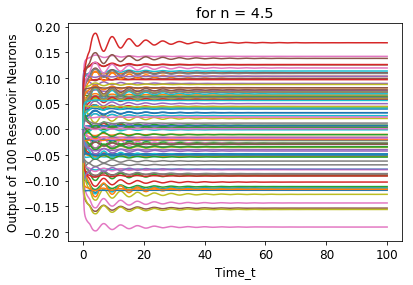

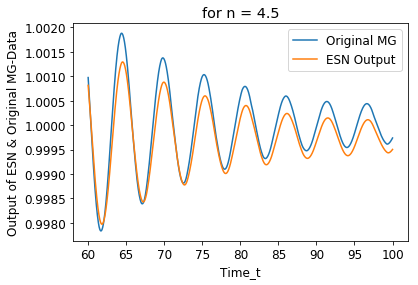



 Value of Spectral Radius for n = 7 : 1.0000011920928955
Mean Squared Error for n = 7 : 1.956091288946027e-08


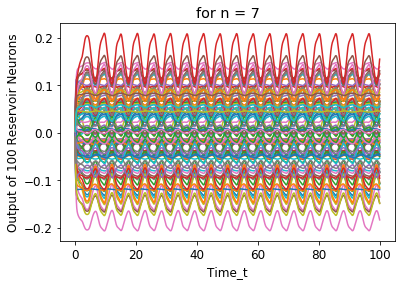

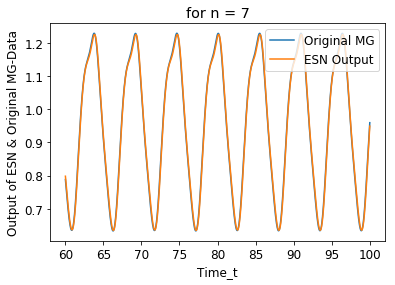



 Value of Spectral Radius for n = 8.5 : 1.0000011920928955
Mean Squared Error for n = 8.5 : 2.669273513333792e-08


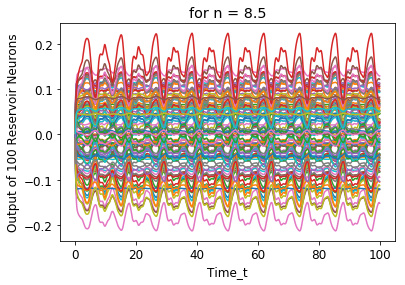

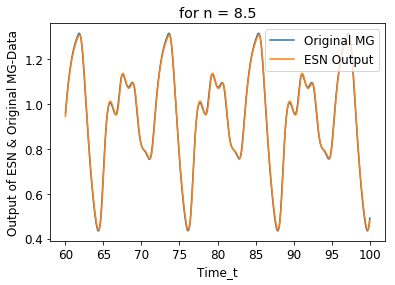



 Value of Spectral Radius for n = 9.5 : 1.0000011920928955
Mean Squared Error for n = 9.5 : 2.8421826669955408e-08


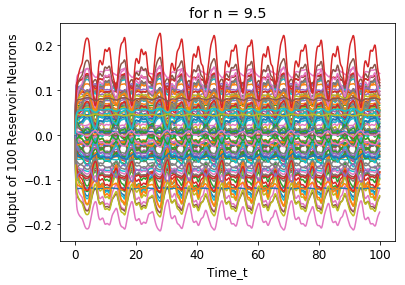

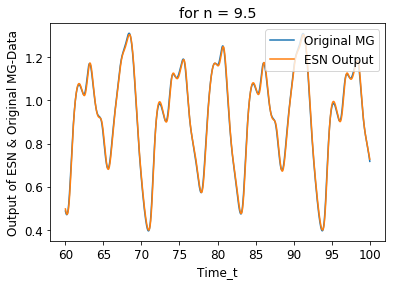



 Value of Spectral Radius for n = 9.65 : 1.0000011920928955
Mean Squared Error for n = 9.65 : 3.0724095267942175e-08


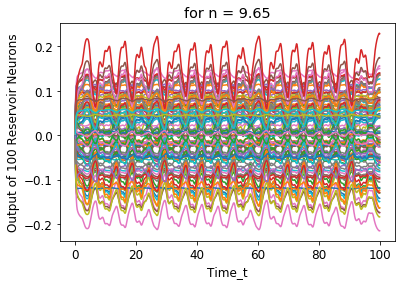

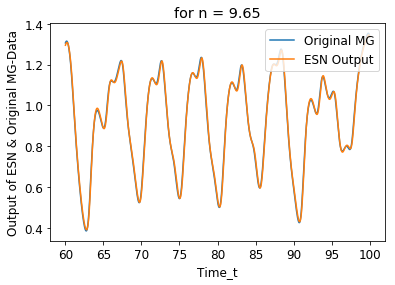



 Value of Spectral Radius for n = 20 : 1.0000011920928955
Mean Squared Error for n = 20 : 7.453376582589044e-08


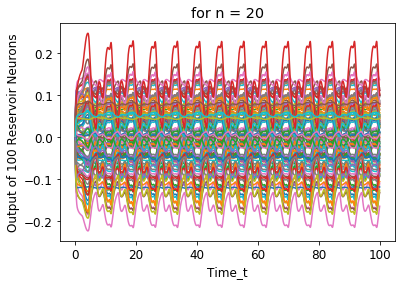

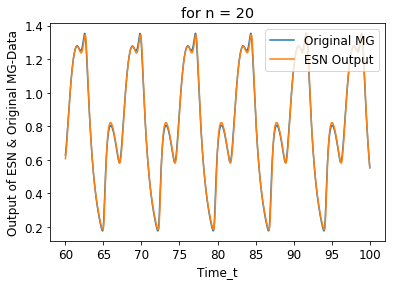

,n,Spectral_Radius,MSE,alpha
1,4.50,1.000001,7.970123e-12,0.1
2,7.00,1.000001,1.956091e-08,0.1
3,8.50,1.000001,2.669274e-08,0.1
4,9.50,1.000001,2.842183e-08,0.1
5,9.65,1.000001,3.072410e-08,0.1
6,20.00,1.000001,7.453377e-08,0.1


In [37]:
with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        
        init_esn_state = np.zeros([1, res_neurons], dtype="float32")              
        
        outputs_dict = {}
        spec_rad_dict = {}
        mse_dict = {}
        
        plt.rcParams.update({'font.size': 12})
        
        for i, n in enumerate(X_ts):
            
            spec_rad, outs, mse, ts_target, ts_out = sess.run([spectral_rad,\
                                                               outputs,MSE,test_target,test_out],\
                                                              feed_dict={inputs:X_ts[n],\
                                                                         init_state:init_esn_state})
            
            df.loc[i+1] = [n, spec_rad, mse, leak_rate]
                
            print("\n\n Value of Spectral Radius for n = {} : {}".format(n, spec_rad))
            print("Mean Squared Error for n = {} : {}".format(n, mse))
            
            plt.figure(1)
            plt.plot(t, outs)
            plt.title("for n = {}".format(n))
            plt.xlabel("Time_t")
            plt.ylabel("Output of {} Reservoir Neurons".format(res_neurons))
            plt.show()
        
            plt.figure(2)
            plt.plot(t[train_size+init_transient+1:], ts_target)
            plt.plot(t[train_size+init_transient+1:], ts_out)
            plt.title("for n = {}".format(n))
            plt.xlabel("Time_t")
            plt.ylabel("Output of ESN & Original MG-Data".format(res_neurons))
            plt.legend(("Original MG","ESN Output"), loc = "upper right")
            plt.show()
            #if n == 4.5: 
                #np.set_printoptions(threshold=sys.maxsize)
                #print(ts_target)
                #print(ts_out)
                #break
            
df

# END